In [2]:
from pathlib import Path
import pandas as pd
import json

In [3]:
 # Determine project root dynamically (works in Jupyter or scripts)
def find_project_root(start_path: Path) -> Path:
    current = start_path
    while current != current.parent:  # Stop at filesystem root
        if (current / "data.json").is_dir():
            return current
        current = current.parent
    raise FileNotFoundError("Project root with 'data.json' directory not found.")

project_root = find_project_root(Path.cwd())

season = 2021

# Construct paths````````````````````````````
season_dir = project_root / "data.json" / "seasons" / str(season)
season_dir.mkdir(parents=True, exist_ok=True)  # Create if missing

# Load files with error handling
def load_parquet(path: Path):
    try:
        return pd.read_parquet(path)
    except FileNotFoundError:
        print(f"File not found: {path}")
        return None

season_dir = project_root / "data.json" / "seasons" / str(season)
fixtures_list = pd.read_parquet(season_dir / f"fixtures_list_{season}.parquet")
fixtures_list = fixtures_list.rename(columns=lambda col: col.replace('.', '_'))
matches = pd.read_parquet(season_dir / "matches.parquet")
events = pd.read_parquet(season_dir / "events.parquet")
teams = pd.read_parquet(season_dir / "teams.parquet")
player_stats = pd.read_parquet(season_dir / "player_stats.parquet")

In [4]:
player_stats.head()

,fixture_id,player_id,player_name,team_id,games_rating,minutes,goals,assists,yellow_cards,red_cards,...,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved
0,710556,19465,David Raya,55,7.9,0,0,0,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.0
1,710556,1119,Kristoffer Ajer,55,6.6,0,0,0,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN
2,710556,19124,Pontus Jansson,55,7,0,0,0,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN
3,710556,19789,Ethan Pinnock,55,7.3,0,0,1,0,0,...,2.0,1.0,NaN,0,0,NaN,NaN,0,0,NaN
4,710556,19352,Sergi Canós,55,8.6,0,1,0,0,0,...,1.0,NaN,NaN,0,0,NaN,NaN,0,0,NaN


In [5]:
# # Assume your original DataFrame: player_stats with 'fixture_id' and 'raw'
# player_stats['raw_dict'] = player_stats['raw'].apply(json.loads)
# flat = pd.json_normalize(player_stats['raw_dict'], sep='_')

# # Reset index for tracking
# flat_expanded = flat.explode('statistics').reset_index()
# stats = pd.json_normalize(flat_expanded['statistics'], sep='_')

# # Concatenate the normalized columns
# final_stats = pd.concat([flat_expanded.drop(columns=['statistics']), stats], axis=1)

# # Map fixture_id using the original DataFrame index
# final_stats['fixture_id'] = flat_expanded['index'].map(player_stats['fixture_id'])

# # Clean column names & fill NaN
# final_stats.columns = final_stats.columns.str.replace('.', '_')
# final_stats = final_stats.fillna(0)

# # Drop the 'index' column
# final_stats = final_stats.drop(columns=['index'])

# final_stats

In [6]:
player_stats.columns

Index(['fixture_id', 'player_id', 'player_name', 'team_id', 'games_rating',
       'minutes', 'goals', 'assists', 'yellow_cards', 'red_cards', 'raw',
       'offsides', 'games_minutes', 'games_number', 'games_position',
       'games_captain', 'games_substitute', 'shots_total', 'shots_on',
       'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves',
       'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
       'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
       'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
       'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_commited', 'penalty_scored', 'penalty_missed',
       'penalty_saved'],
      dtype='object')

In [7]:
expected_ids = set(fixtures_list["fixture_id"])
actual_ids = set(matches["fixture_id"])
missing_ids = expected_ids - actual_ids
print(f"Missing fixtures in matches data.json: {sorted(missing_ids)}")

Missing fixtures in matches data: []


In [8]:
invalid_events = events[~events["fixture_id"].isin(actual_ids)]
invalid_stats = player_stats[~player_stats["fixture_id"].isin(actual_ids)]
invalid_players = player_stats[~player_stats["player_id"].isin(player_stats["player_id"].unique())]

In [9]:
matches

,fixture_id,date,timestamp,referee,venue_id,venue_name,status,league_id,round,home_team_id,home_team_name,away_team_id,away_team_name,ft_home,ft_away,ht_home,ht_away
0,710556,2021-08-13T19:00:00+00:00,1628881200,M. Oliver,10503,Brentford Community Stadium,FT,39,Regular Season - 1,55,Brentford,42,Arsenal,2,0,1,0
1,710557,2021-08-14T14:00:00+00:00,1628949600,D. Coote,512,Turf Moor,FT,39,Regular Season - 1,44,Burnley,51,Brighton,1,2,1,0
2,710558,2021-08-14T14:00:00+00:00,1628949600,J. Moss,519,Stamford Bridge,FT,39,Regular Season - 1,49,Chelsea,52,Crystal Palace,3,0,2,0
3,710559,2021-08-14T14:00:00+00:00,1628949600,A. Madley,8560,Goodison Park,FT,39,Regular Season - 1,45,Everton,41,Southampton,3,1,0,1
4,710560,2021-08-14T14:00:00+00:00,1628949600,C. Pawson,547,King Power Stadium,FT,39,Regular Season - 1,46,Leicester,39,Wolves,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,710931,2022-05-22T15:00:00+00:00,1653231600,M. Atkinson,525,Selhurst Park,FT,39,Regular Season - 38,52,Crystal Palace,33,Manchester United,1,0,1,0
376,710932,2022-05-22T15:00:00+00:00,1653231600,J. Moss,547,King Power Stadium,FT,39,Regular Season - 38,46,Leicester,41,Southampton,4,1,0,0
377,710933,2022-05-22T15:00:00+00:00,1653231600,A. Taylor,550,Anfield,FT,39,Regular Season - 38,40,Liverpool,39,Wolves,3,1,1,1
378,710934,2022-05-22T15:00:00+00:00,1653231600,M. Oliver,555,Etihad Stadium,FT,39,Regular Season - 38,50,Manchester City,66,Aston Villa,3,2,0,1


In [10]:
print(matches['ft_home'].isna().sum())
print(matches['ft_away'].isna().sum())

0
0


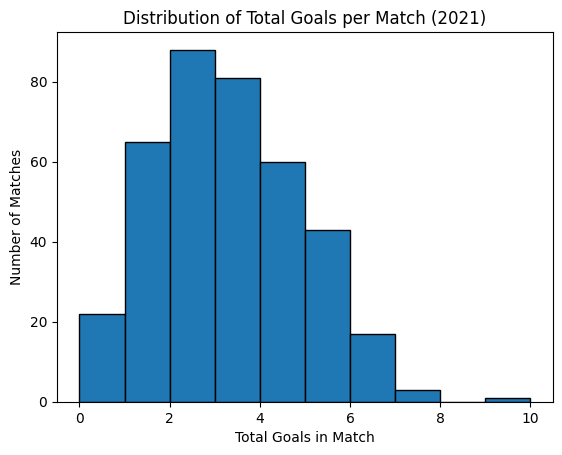

In [11]:
import matplotlib.pyplot as plt

total_goals = matches["ft_home"].dropna() + matches["ft_away"].dropna()
plt.hist(total_goals, bins=range(0, max(total_goals)+2), edgecolor='black')
plt.title(f"Distribution of Total Goals per Match ({season})")
plt.xlabel("Total Goals in Match")
plt.ylabel("Number of Matches")
plt.show()